## Match career advice questions with professionals in the field
**Objective**

Develop a method to recommend relevant questions to the professionals who are most likely to answer them 

In [1]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 22.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rake_nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.1/757.1 kB 68.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
questions=pd.read_csv('questions.csv',nrows=5000)
scores=pd.read_csv('question_scores.csv',nrows=5000)

In [13]:
 questions.drop(['Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'],axis=1,inplace=True)
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,To become a specialist in business management...,i hear business management is a hard way to ge...
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...


In [6]:
scores.head()

,id,score
0,38436aadef3d4b608ad089cf53ab0fe7,5
1,edb8c179c5d64c9cb812a59a32045f55,4
2,333464d7484b43e3866e86096bc4ddb9,6
3,4b995e60b99d4ee18346e893e007cb8f,6
4,f6b9ca94aed04ba28256492708e74f60,6


In [7]:
#check for nulls & duplicates
print("Nulls")
print(questions.columns.isnull().sum())
print(scores.columns.isnull().sum())
print("Duplicates")
print(questions.columns.duplicated().sum())
print(scores.columns.duplicated().sum())
#print(questions.shape)

Nulls
0
0
Duplicates
0
0


## Data Preprocessing

- The main columns are question title and question body 
    * Expand Contractions
    * Convert all characters to lowercase
    * Remove punctuations, whitespace and stopwords
    * Perform tokenization
    * Perform Lemmatization


In [14]:
# contractions are word shortcuts like , don't, ain't, we've, should've. 
# Expanding them makes the words longer.
questions['questions_title']= questions['questions_title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
questions['questions_body']= questions['questions_body'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [15]:
#change it to string inorder to tokenize

questions['questions_title_str']=[' '.join(map(str,w)) for w in questions['questions_title']]
questions['questions_body_str']= [' '.join(map(str,w)) for w in questions['questions_body']]
questions.sample(10)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str
1460,7ec655df73814558aad27669a023f7e5,679bd6886b7d43fca9ca2e05e48f4b6b,2018-01-12 09:01:31 UTC+0000,"[How, can, i, determine, price, for, my, decals]","[I, have, done, an, intensive, research, to, i...",How can i determine price for my decals,I have done an intensive research to identify ...
2420,1a4cbb41b57b482e86dde25d7b9ccc97,8de792cf72f74f668c79f73e3bdd1562,2016-05-20 01:33:03 UTC+0000,"[Can, one, pursue, a, lucrative, career, in, I...","[I, am, a, college, student, pursuing, an, A.A...",Can one pursue a lucrative career in I.T. with...,I am a college student pursuing an A.A.S in co...
237,1bd8b24611384bbcb7cd099ba7436ed7,8524d5a6063445bcb40ef47849513eab,2018-11-15 22:15:44 UTC+0000,"[How, long, have, you, been, working, in, the,...","[I am, enrolled, at, job, corps, and, I, am, g...",How long have you been working in the mechanic...,I am enrolled at job corps and I am going into...
537,13faae55249f419d9c9906f9f4bd590a,9f5908e2a8f94ae09e42083a2075a3d3,2018-07-09 04:11:47 UTC+0000,"[How, can, I, decide, on, what, category, of, ...","[I am, Iris, and, I, have, always, loved, all,...",How can I decide on what category of biology I...,I am Iris and I have always loved all things s...
968,1b5b7f42e4d54132a19d7db89e31f850,d6fd36c651bb4508be1799ce71170173,2019-01-15 03:14:47 UTC+0000,"[what, are, different, types, of, engineering?]","[#engineering, #student, #major]",what are different types of engineering?,#engineering #student #major
4992,956729905ca645c6a559bec172b6d2a7,41d3cb0603ad417aac472c032be529ba,2014-12-02 19:21:22 UTC+0000,"[How, long, does, it, take, to, make, it, big,...","[My, name, is, Jakiel, and, I, am, a, junior, ...",How long does it take to make it big in the mu...,My name is Jakiel and I am a junior at Boston ...
84,aed337da791c42d399781b965dd4dc2e,87a010c71f2b405cb401747fefab85de,2016-05-16 23:53:14 UTC+0000,"[Do, public, defenders, have, the, same, requi...","[Are not, they, technically, government, emplo...",Do public defenders have the same requirement ...,Are not they technically government employees?...
3995,a91d02d3894748e89636e0ab6f20fdc4,50ecdb753d2f47db8866deb5d3a1bdd3,2018-08-27 02:35:51 UTC+0000,"[What, are, some, things, tat, you, can, do, t...","[How, do, I/can, I, prepare, for, college, #do...",What are some things tat you can do to help yo...,How do I/can I prepare for college #dormlife #...
938,78d27a9f6f8e447c8c204e89d108cf9d,4207014c6e23459789201b8a0db5b4f1,2016-04-27 10:11:43 UTC+0000,"[What, are, some, careers, I, could, expect, t...","[I, do not, know, much, about, my, options, in...",What are some careers I could expect to get if...,I do not know much about my options in biology...
734,f082944f32434c3d9dddab588384cfea,ab3cecfa7742485084696877ba710ed0,2016-10-11 20:59:16 UTC+0000,"[What is, the, difference, between, a, Ph.D, a...","[I, want, to, become, a, clinical, psychologis...",What is the difference between a Ph.D and Psy.D?,I want to become a clinical psychologist but I...


In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:

#Tokenization
questions['questions_title_tokenize']= questions['questions_title_str'].apply(word_tokenize)
questions['questions_body_tokenize']= questions['questions_body_str'].apply(word_tokenize)
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ..."
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,..."
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f..."


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
#remove punctuations and stopwords
p=string.punctuation
stop_words=stopwords.words('english')
questions['questions_title_nopunc']=questions['questions_title_tokenize'].apply( lambda x: [word for word in x if word not in p])
questions['questions_body_nopunc']=questions['questions_body_tokenize'].apply( lambda x: [word for word in x if word not in p])
#stopwords
questions['questions_title_nostpwords']=questions['questions_title_nopunc'].apply( lambda x: [word for word in x if word not in stop_words])
questions['questions_body_nostpwords']=questions['questions_body_nopunc'].apply( lambda x: [word for word in x if word not in stop_words])
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize,questions_title_nopunc,questions_body_nopunc,questions_title_nostpwords,questions_body_nostpwords
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ...","[Teacher, career, question]","[What, is, a, maths, teacher, what, is, a, mat...","[Teacher, career, question]","[What, maths, teacher, maths, teacher, useful,..."
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,...","[I, want, to, become, an, army, officer, What,...","[I, am, Priyanka, from, Bangalore, Now, am, in...","[I, want, become, army, officer, What, I, beco...","[I, Priyanka, Bangalore, Now, 10th, std, When,..."
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[Will, going, abroad, first, job, increase, ch...","[I, planning, going, abroad, first, job, It, t..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[To, become, specialist, business, management,...","[hear, business, management, hard, way, get, j..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[Are, scholarships, students, first, generatio...","[I, trying, find, scholarships, first, year, s..."


In [18]:
#remove white spaces and change to lowercase
for index, row in questions.iterrows():
    row['questions_title_nostpwords']=[x.lower().replace('','') for x in row['questions_title_nostpwords']]
    row['questions_body_nostpwords']=[x.lower().replace('','') for x in row['questions_body_nostpwords']]
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize,questions_title_nopunc,questions_body_nopunc,questions_title_nostpwords,questions_body_nostpwords
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ...","[Teacher, career, question]","[What, is, a, maths, teacher, what, is, a, mat...","[teacher, career, question]","[what, maths, teacher, maths, teacher, useful,..."
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,...","[I, want, to, become, an, army, officer, What,...","[I, am, Priyanka, from, Bangalore, Now, am, in...","[i, want, become, army, officer, what, i, beco...","[i, priyanka, bangalore, now, 10th, std, when,..."
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[will, going, abroad, first, job, increase, ch...","[i, planning, going, abroad, first, job, it, t..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[to, become, specialist, business, management,...","[hear, business, management, hard, way, get, j..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[are, scholarships, students, first, generatio...","[i, trying, find, scholarships, first, year, s..."


In [19]:
# find the keywords in questions body using Rake()
questions['keywords']=' '
R= Rake()
for index, row in questions.iterrows():
    R.extract_keywords_from_text(row['questions_title_str'])
    key_words= R.get_word_degrees()
    row['keywords'] = list(key_words.keys())
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize,questions_title_nopunc,questions_body_nopunc,questions_title_nostpwords,questions_body_nostpwords,keywords
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ...","[Teacher, career, question]","[What, is, a, maths, teacher, what, is, a, mat...","[teacher, career, question]","[what, maths, teacher, maths, teacher, useful,...","[teacher, career, question]"
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,...","[I, want, to, become, an, army, officer, What,...","[I, am, Priyanka, from, Bangalore, Now, am, in...","[i, want, become, army, officer, what, i, beco...","[i, priyanka, bangalore, now, 10th, std, when,...","[want, become, army, officer]"
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[will, going, abroad, first, job, increase, ch...","[i, planning, going, abroad, first, job, it, t...","[going, abroad, first, job, increase, chances,..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[to, become, specialist, business, management,...","[hear, business, management, hard, way, get, j...","[become, specialist, business, management, net..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[are, scholarships, students, first, generatio...","[i, trying, find, scholarships, first, year, s...","[scholarships, students, first, generation, li..."


In [32]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
#lemmatization
#first i need to apply the POS tags and lemmatize
questions['questions_body_pos']=questions['questions_body_nostpwords'].apply(nltk.tag.pos_tag)
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize,questions_title_nopunc,questions_body_nopunc,questions_title_nostpwords,questions_body_nostpwords,keywords,questions_body_pos
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ...","[Teacher, career, question]","[What, is, a, maths, teacher, what, is, a, mat...","[teacher, career, question]","[what, maths, teacher, maths, teacher, useful,...","[teacher, career, question]","[(what, WP), (maths, VBZ), (teacher, JJR), (ma..."
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,...","[I, want, to, become, an, army, officer, What,...","[I, am, Priyanka, from, Bangalore, Now, am, in...","[i, want, become, army, officer, what, i, beco...","[i, priyanka, bangalore, now, 10th, std, when,...","[want, become, army, officer]","[(i, NN), (priyanka, VBP), (bangalore, RB), (n..."
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[will, going, abroad, first, job, increase, ch...","[i, planning, going, abroad, first, job, it, t...","[going, abroad, first, job, increase, chances,...","[(i, NN), (planning, VBG), (going, VBG), (abro..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[to, become, specialist, business, management,...","[hear, business, management, hard, way, get, j...","[become, specialist, business, management, net...","[(hear, NN), (business, NN), (management, NN),..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[are, scholarships, students, first, generatio...","[i, trying, find, scholarships, first, year, s...","[scholarships, students, first, generation, li...","[(i, NN), (trying, VBG), (find, VB), (scholars..."


In [40]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...


True

In [21]:
#convert to wordnet inorder to lemmatize
def for_wordnet(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
questions['questions_body_wordnet']=questions['questions_body_pos'].apply( lambda x: [(word,for_wordnet(tag)) for (word,tag) in x ])

In [22]:
wl=WordNetLemmatizer()
questions['questions_body_lemmatize']=questions['questions_body_wordnet'].apply(lambda x:[wl.lemmatize(word,tag) for(word,tag) in x])

In [45]:
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_title_str,questions_body_str,questions_title_tokenize,questions_body_tokenize,keywords,questions_title_nopunc,questions_body_nopunc,questions_title_nostpwords,questions_body_nostpwords,questions_body_pos,questions_body_wordnet,questions_body_lemmatize
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,"[Teacher, career, question]","[What, is, a, maths, teacher?, what, is, a, ma...",Teacher career question,What is a maths teacher? what is a maths teach...,"[Teacher, career, question]","[What, is, a, maths, teacher, ?, what, is, a, ...","[teacher, career, question]","[Teacher, career, question]","[What, is, a, maths, teacher, what, is, a, mat...","[teacher, career, question]","[what, maths, teacher, maths, teacher, useful,...","[(what, WP), (maths, VBZ), (teacher, JJR), (ma...","[(what, n), (maths, v), (teacher, a), (maths, ...","[what, maths, teacher, math, teacher, useful, ..."
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,"[I, want, to, become, an, army, officer., What...","[I, am, Priyanka, from, Bangalore, ., Now, am,...",I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,"[I, want, to, become, an, army, officer, ., Wh...","[I, am, Priyanka, from, Bangalore, ., Now, am,...","[want, become, army, officer]","[I, want, to, become, an, army, officer, What,...","[I, am, Priyanka, from, Bangalore, Now, am, in...","[i, want, become, army, officer, what, i, beco...","[i, priyanka, bangalore, now, 10th, std, when,...","[(i, NN), (priyanka, VBP), (bangalore, RB), (n...","[(i, n), (priyanka, v), (bangalore, r), (now, ...","[i, priyanka, bangalore, now, 10th, std, when,..."
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,"[Will, going, abroad, for, your, first, job, i...","[I am, planning, on, going, abroad, for, my, f...",Will going abroad for your first job increase ...,I am planning on going abroad for my first job...,"[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[going, abroad, first, job, increase, chances,...","[Will, going, abroad, for, your, first, job, i...","[I, am, planning, on, going, abroad, for, my, ...","[will, going, abroad, first, job, increase, ch...","[i, planning, going, abroad, first, job, it, t...","[(i, NN), (planning, VBG), (going, VBG), (abro...","[(i, n), (planning, v), (going, v), (abroad, r...","[i, plan, go, abroad, first, job, it, teach, j..."
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","To become a specialist in business management,...",i hear business management is a hard way to ge...,"[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[become, specialist, business, management, net...","[To, become, a, specialist, in, business, mana...","[i, hear, business, management, is, a, hard, w...","[to, become, specialist, business, management,...","[hear, business, management, hard, way, get, j...","[(hear, NN), (business, NN), (management, NN),...","[(hear, n), (business, n), (management, n), (h...","[hear, business, management, hard, way, get, j..."
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,"[Are, there, any, scholarships, out, there, fo...","[I am, trying, to, find, scholarships, for, fi...",Are there any scholarships out there for stude...,I am trying to find scholarships for first yea...,"[Are, there, any, scholarships, out, there, fo...","[I, am, trying, to, find, scholarships, for, f...","[scholarships, students, first, generation, li...","[Are, there, any, scholarships, out, there, fo...","[I, am, tryi

In [23]:
# convert it to a pickle file and prepare for EDA
questions.to_pickle('scraped_questions.pkl')

## EDA

In [12]:
import pickle
with open('scraped_questions.pkl','rb') as scraped_file:
    df_scraped=pickle.load(scraped_file)

In [3]:
#create a wordcloud
from nltk.probability import FreqDist
#convert the lemmatized word into a list
words_scraped=df_scraped[['keywords','questions_body_lemmatize']]
word=words_scraped['questions_body_lemmatize']
everyword=[]
for list_of_words in word:
    everyword+=list_of_words
#print(everyword)

In [5]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 8.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


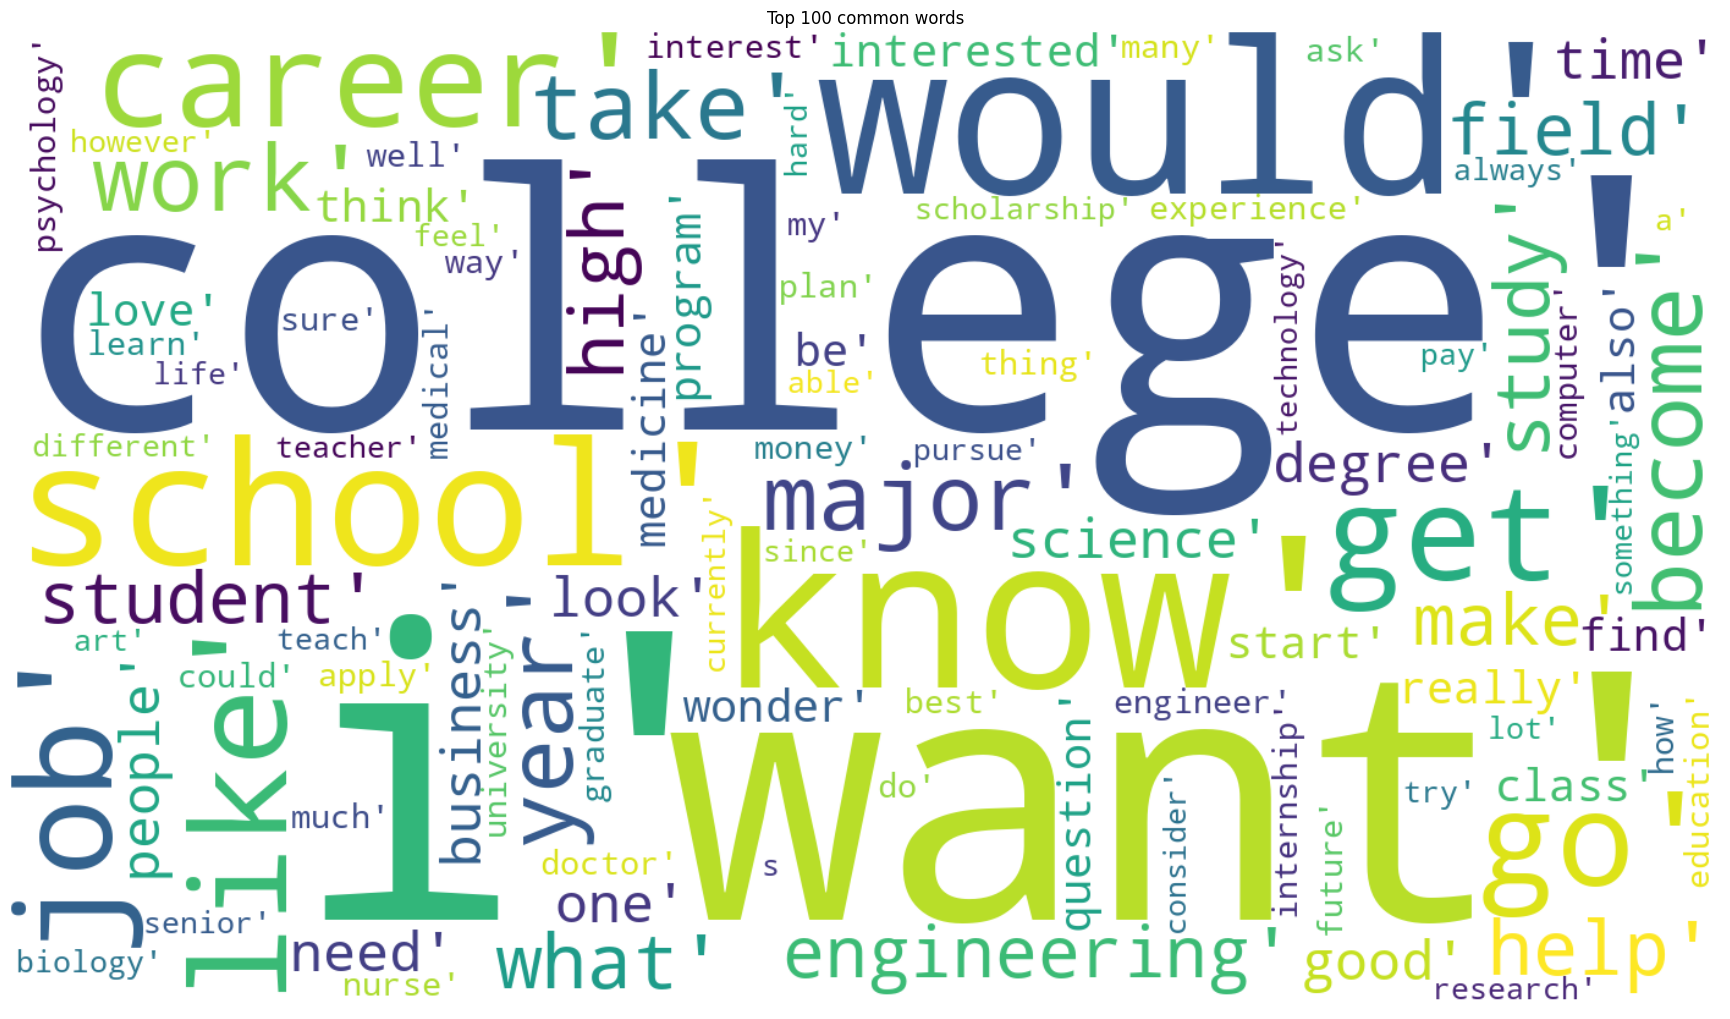

In [29]:
commonwords=FreqDist(everyword).most_common(100)
from wordcloud import WordCloud,ImageColorGenerator
cloud=WordCloud(width=1400, height=800, background_color='white').generate(str(commonwords))

fig=plt.figure(figsize=(30,10))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 common words')
plt.tight_layout(pad=0)
plt.show()

### Deductions
the most common words are:

    - College
    - Career
    - Job
    - school
    - work

In [23]:
# next, lets take a look at the ratings for questions
import seaborn as sns
score_value=scores.score.value_counts()
score_table=pd.DataFrame(data=score_value)
score_table


,score
2,1114
1,977
3,956
4,650
5,454
6,260
7,162
8,86
9,66
0,53


- i think the number of scores refers to the questions that have been given an upvote because this is not the same as give a rating

In [6]:
#lets look at how we can find themes or topics for our questions
#using non-negative matrix factorization(NMF) and TFDIF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [8]:
# change the column to string first
words_scraped['lemmatize']= [''.join(map(str,l)) for l in words_scraped['questions_body_lemmatize']]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
tf_vectorizer=TfidfVectorizer(max_df=0.9, min_df=25,max_features=5000,use_idf=True)
tf=tf_vectorizer.fit_transform(words_scraped['lemmatize'])
tf_featurenames=tf_vectorizer.get_feature_names_out()
matrix_tf=pd.DataFrame(tf.toarray(),columns=list(tf_featurenames))
matrix_tf


,admissionscollege,advice,aid,and,care,college,counseling,counselingcareer,design,details,...,health,in,life,major,majorcollege,management,planning,school,science,sciencecomputer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# display topics
no_topwords=10
def show_topics(model,feature_names,no_topwords):
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" %(topic_index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_topwords -1:-1]]))

In [14]:
nmf= NMF(n_components=10,random_state=0,alpha=1,init='nndsvd').fit(tf)
show_topics(nmf,tf_featurenames,no_topwords)

Topic 0:
and health care counseling details planning aid majorcollege counselingcareer school
Topic 1:
engineering sciencecomputer majorcollege in admissionscollege design details advice aid and
Topic 2:
school and in sciencecomputer development advice aid care college counseling
Topic 3:
management admissionscollege life majorcollege planning details health advice counselingcareer aid
Topic 4:
major majorcollege counselingcareer care admissionscollege life details advice aid and
Topic 5:
science counselingcareer life in details majorcollege sciencecomputer advice aid and
Topic 6:
in life sciencecomputer majorcollege care health school details engineering science
Topic 7:
education life majorcollege admissionscollege details counseling health counselingcareer engineer design
Topic 8:
college advice majorcollege admissionscollege life aid planning and details counselingcareer
Topic 9:
development counselingcareer sciencecomputer majorcollege and design details admissionscollege advice i

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


### Topics
- Topic1:Counselling and health care
- Topic2: Engineering and Computer science
- Topic3: Advice on Computerstudies
- Topic4: Planning college
- Topic5: College life
- Topic6: Career in computer science
- Topic7: Details about college majors
- Topic8: Design
- Topic9: Career in counselling
- Topic 10:College Admissions

In [18]:
#lets try and use another model to come up with topics and see the differences
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
c_vectorizer=CountVectorizer(max_df=0.9, min_df=25,max_features=5000)
cf=tf_vectorizer.fit_transform(words_scraped['lemmatize'].values.astype('U'))
cf_featurenames=tf_vectorizer.get_feature_names_out()
matrix_cf=pd.DataFrame(cf.toarray(),columns=list(cf_featurenames))
matrix_cf

,admissionscollege,advice,aid,and,care,college,counseling,counselingcareer,design,details,...,health,in,life,major,majorcollege,management,planning,school,science,sciencecomputer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
lda=LatentDirichletAllocation(n_components=10,learning_method="online",max_iter=500,random_state=0).fit(cf)
show_topics(lda,cf_featurenames,no_topwords)

Topic 0:
design sciencecomputer admissionscollege majorcollege in and counseling development science planning
Topic 1:
school counselingcareer in development majorcollege and science major admissionscollege sciencecomputer
Topic 2:
engineering engineer sciencecomputer majorcollege in admissionscollege and counseling development science
Topic 3:
major details majorcollege sciencecomputer and counselingcareer health life care admissionscollege
Topic 4:
and health care counseling details in development major majorcollege aid
Topic 5:
college advice admissionscollege majorcollege life and aid in sciencecomputer counseling
Topic 6:
management admissionscollege majorcollege life in sciencecomputer and counseling development science
Topic 7:
in education development majorcollege admissionscollege school counselingcareer sciencecomputer life engineering
Topic 8:
aid life majorcollege admissionscollege in college education science details management
Topic 9:
science counseling planning sciencec

In [35]:
questions=pd.read_csv('questions.csv',nrows=5000)
words_scraped['questions_title']=questions['questions_title']
words_scraped.head()

,keywords,questions_body_lemmatize,lemmatize,new_words,questions_title
0,"[teacher, career, question]","[what, maths, teacher, math, teacher, useful, ...",whatmathsteachermathteacherusefulcollegeprofes...,teacher career question what maths teacher mat...,Teacher career question
1,"[want, become, army, officer]","[i, priyanka, bangalore, now, 10th, std, when,...",ipriyankabangalorenow10thstdwhenigocollegeiget...,want become army officer i priyanka bangalore ...,I want to become an army officer. What can I d...
2,"[going, abroad, first, job, increase, chances,...","[i, plan, go, abroad, first, job, it, teach, j...",iplangoabroadfirstjobitteachjobiseriouscareeri...,going abroad first job increase chances jobs b...,Will going abroad for your first job increase ...
3,"[become, specialist, business, management, net...","[hear, business, management, hard, way, get, j...",hearbusinessmanagementhardwaygetjobknowrightar...,become specialist business management network ...,To become a specialist in business management...
4,"[scholarships, students, first, generation, li...","[i, try, find, scholarship, first, year, stude...",itryfindscholarshipfirstyearstudentseemstatebe...,scholarships students first generation live ga...,Are there any scholarships out there for stude...


In [31]:
#next step is to try build a recommender model
#features: keywords and question_body_lemmatize
words_scraped['new_words']= ''
columns=['keywords', 'questions_body_lemmatize']
for index,row in words_scraped.iterrows():
    words=''
    for col in columns:
        words+= ' '.join(row[col]) + ' '
    row['new_words'] = words
    

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
count=CountVectorizer()
word_matrix=count.fit_transform(words_scraped['new_words'])
cosine=cosine_similarity(word_matrix,word_matrix)
print(cosine)

[[1.         0.07856742 0.02311251 ... 0.         0.         0.04622502]
 [0.07856742 1.         0.03268602 ... 0.         0.         0.06537205]
 [0.02311251 0.03268602 1.         ... 0.01570186 0.01706972 0.        ]
 ...
 [0.         0.         0.01570186 ... 1.         0.         0.03140371]
 [0.         0.         0.01706972 ... 0.         1.         0.        ]
 [0.04622502 0.06537205 0.         ... 0.03140371 0.         1.        ]]


In [37]:
# Next is to create a Series of question titles, so that the series index can match the row and column index of the similarity matrix.
title_index = pd.Series(words_scraped['questions_title'])

In [43]:
def Question(title, cosine= cosine):
    recommend_questions = []
    idx = title_index[title_index == title].index[0]
    score_series = pd.Series(cosine[idx]).sort_values(ascending = False)
    top_10_questions = list(score_series.iloc[1:11].index)
    
    for i in top_10_questions:
        recommend_questions.append(list(words_scraped['questions_title'])[i])
        
    return recommend_questions

In [44]:
Question('Scholarships')

['How can I get the scholarships I need?',
 'Which are the best ways to get scholarships',
 'How do I stand out when applying for scholarships?',
 'Where do I find viable scholarships?',
 'Will a scholarship cover my basics?',
 'Can you continue getting scholarships?',
 'What are some ways to get more scholarship money?',
 'What are some credible scholarship websites?',
 'How to find good scholarships?',
 'What is the best way to find a scholarship?']

In [49]:
Question('career')

IndexError: index 0 is out of bounds for axis 0 with size 0